<a href="https://colab.research.google.com/github/TheBlackRus/liveproject_HumanPoseEstimation/blob/master/liveproject_humanpose_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 01 Download the data

In [36]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2020-04-27 23:41:25--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat.1’

train_32x32.mat.1    65%[============>       ] 114.41M  19.8MB/s    eta 4s     ^C
--2020-04-27 23:41:33--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat.1’

test_32x32.mat.1    100%[===================>]  61.30M  18.6MB/s    in 3.9s    

2020-04-27 23:41:37 (15.7 MB/s) - ‘test_32x32.mat.1’ saved [64275384/64275384]



In [0]:
# 02 display the data

In [0]:
from scipy.io import loadmat
train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')

Digital Label 1


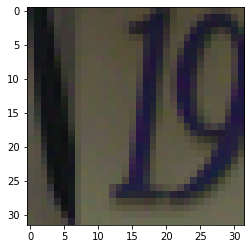

In [39]:
from matplotlib.pyplot import imshow

X = train["X"]
y = train["y"]
example = 0
assert(example < y.shape[0])

print("Digital Label", y[example][0])
imshow(X[:,:,:,example])

In [0]:
# 03 COCO

In [41]:
# This code downloads the coco dataset from Amazon S3 in parallel.
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import multiprocessing
import subprocess
files = ['val2017.zip', 'annotations_trainval2017.zip']#, 'train2017.zip']

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
def download_and_unzip_from_s3(file_name, bucket_name='fast-ai-coco'):
    print("Downloading", file_name)
    s3.download_file(bucket_name, file_name, file_name)
    print("Finished downloading", file_name, ". Starting to unzip.")
    subprocess.run(["unzip", file_name])
    print("Finished unzipping", file_name)

# Download in parallel
num_cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(num_cpus) as p:
    p.map(download_and_unzip_from_s3, files)

print("Done transferring all datasets")

Finished downloading annotations_trainval2017.zip . Starting to unzip.
Finished unzipping annotations_trainval2017.zip
Finished downloading val2017.zip . Starting to unzip.
Finished unzipping val2017.zip
Done transferring all datasets


In [0]:
# read the meta data of the validation set
import json
file_name = "annotations//person_keypoints_val2017.json"
with open(file_name, 'r') as json_raw:
    meta = json.load(json_raw)



In [43]:
# get its structure
meta.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [0]:
example = 0
img_info = meta["images"][example]
img_annotation = meta["annotations"][example]
img_catogory = meta["categories"][0]["keypoints"]

In [45]:
# view the structure
print(meta["categories"][0]['keypoints'])
print(img_info.keys())
print(img_annotation.keys())

['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']
dict_keys(['license', 'file_name', 'coco_url', 'height', 'width', 'date_captured', 'flickr_url', 'id'])
dict_keys(['segmentation', 'num_keypoints', 'area', 'iscrowd', 'keypoints', 'image_id', 'bbox', 'category_id', 'id'])


In [46]:
img_file = str(img_annotation["image_id"])
img_file = img_file.zfill(12) +".jpg" #img_info["file_name"]
print(img_file, img_annotation["image_id"])

000000425226.jpg 425226


In [0]:
def resize_image(img, target_width=192, target_height=256):
  img_resized = cv2.resize(img,(target_width,target_height))
  return img_resized

def crop_image(img, upper_left_corner, size):
  start_x, start_y = upper_left_corner
  w,h = size
  img_cropped = img[int(start_y):(int(start_y+h)),int(start_x):int(start_x+w),:]
  return img_cropped

def adjust_keypoint(keypoint, start, scale):
  keypoint_x, keypoint_y= keypoint
  start_x,start_y = start
  sx,sy = scale
  x = (keypoint_x-start_x)*sx
  y = (keypoint_y-start_y)*sy
  return x,y



(640, 480, 3) 73.35 206.02 300.58 372.5


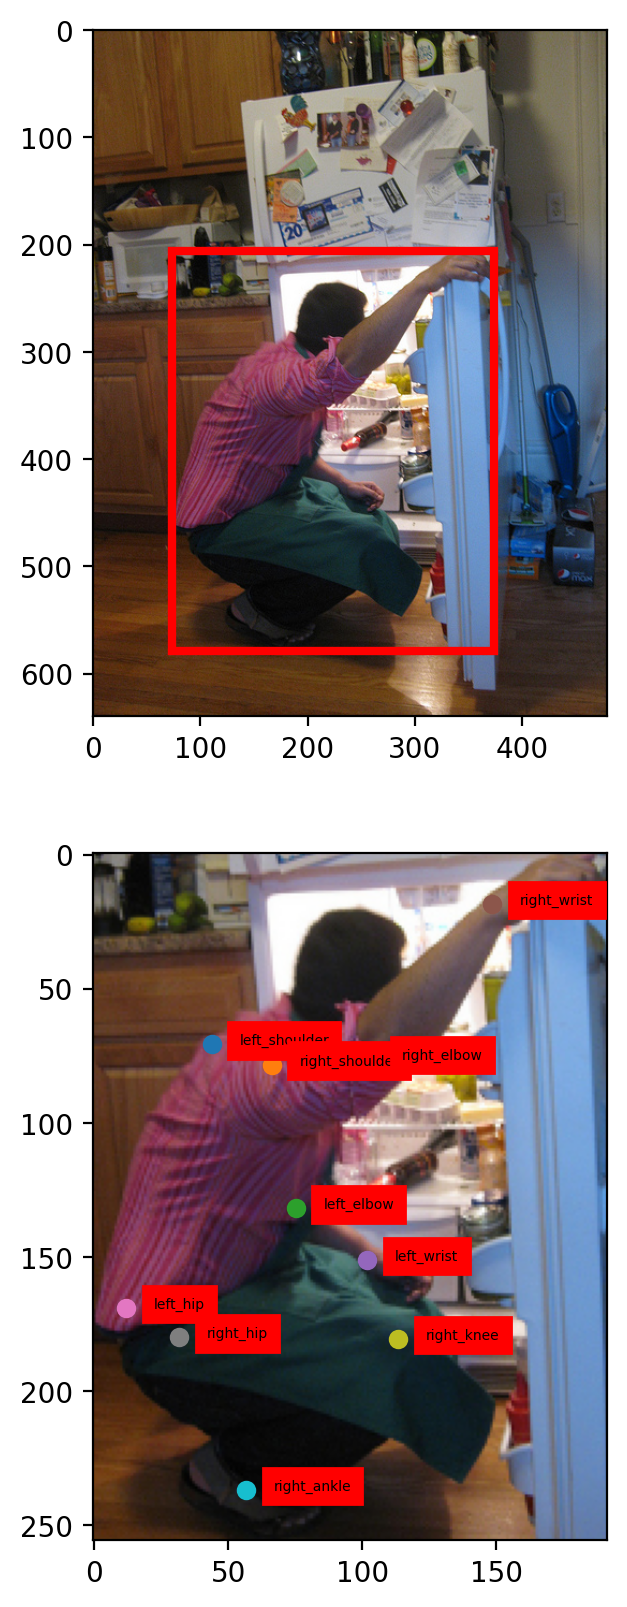

In [48]:
%matplotlib inline
#from matplotlib.pyplot import imshow
from matplotlib import image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

# params
target_width = 192
target_height= 256

keypoints = img_annotation["keypoints"]

# plot
fig,ax = plt.subplots(2,figsize=(20,10))
fig.set_dpi(200)


img = image.imread("val2017//"+img_file)
start_x,start_y, w,h = img_annotation["bbox"]
print(img.shape,start_x,start_y,w,h)


r = patches.Rectangle((start_x,start_y),w,h,linewidth=3,edgecolor='r',facecolor='None')

ax[0].imshow(img)
ax[0].add_patch(r)

img_crop = crop_image(img, (start_x,start_y),(w,h))
img_crop = resize_image(img_crop,target_width,target_height)


sx = target_width/w 
sy = target_height/h

ax[1].imshow(img_crop)



for i in range(len(keypoints)//3):
  keypoint = (keypoints[i*3],keypoints[i*3+1])
  visible = keypoints[i*3+2]
  x,y = adjust_keypoint(keypoint,(start_x,start_y),(sx,sy))
  
  if visible:
    # ax.text(x, y, "x")
    label = img_catogory[i]
    ax[1].annotate(label,
                 (x,y), 
                 textcoords="offset points",
                 size=5,
                 xytext=(10,0),
                 ha='left',
                 backgroundcolor="r")
    
    ax[1].scatter(x,y)
    
plt.show()